#  Librairies 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import random
from networkx.drawing.nx_agraph import graphviz_layout
from __future__ import division 
from operator import itemgetter
from itertools import count
from networkx.drawing.nx_pydot import write_dot
from IPython.display import Image
import pylab

# Exemple jouet

Afin de faciliter l'écriture des algorithmes et afin de vérifier leur pertinence nous avons généré un jeu de données, pour lequel la recherche du nombre d'inversions est triviale. Cet exemple peut être résumé tel que : 
* Organisme A : (+)A  - (+)B - (+)C - (+)D - (+)E
* Organisme B : (-)D  - (-)C - (+)A - (+)B - (+)E  

Le signe (+) implique que la position du début du gène est inféfieure à celle de la fin, et réciproquement pour le signe (-).

## Construction de la matrice

In [3]:
d_ref_jouet = {'ID': ["A", "B", "C","D","E"], 'Qstart': [0, 2,4,6, 8],'Qend': [1, 3,5,7,9]  }
d_int_jouet = {'ID': ["A", "B", "C","D","E"], 'Sstart': [4,6,3,1, 8], 'Send': [5, 7,2,0, 9] }
d_ref_jouet=  pd.DataFrame(data=d_ref_jouet)
d_int_jouet=  pd.DataFrame(data=d_int_jouet)
d_int_jouet= d_int_jouet.sort_values('Sstart')
print(d_ref_jouet)
print(d_int_jouet)

  ID  Qend  Qstart
0  A     1       0
1  B     3       2
2  C     5       4
3  D     7       6
4  E     9       8
  ID  Send  Sstart
3  D     0       1
2  C     2       3
0  A     5       4
1  B     7       6
4  E     9       8


## Recherche des arcs

In [4]:
def find_edges(d, ref):
    """Cette fonction permet de chercher les arcs, soit les gènes adjacents sur un chromosome. Cette fonction prend en
    argument  la matrices des positions de début et de fin, de chaque segement orthologue. Cette matrice doit être triée
    selon les positions de début. Pour chaque gène, la fonction `find_edge`, détermine la 'fin' de l'arc comme étant la position
    maximale du gène courant (i) et détermine le début de cette arc comme la position minimale du gène suivant (i+1). Enfin étant 
    donné que nous étudions des chromosomes bactériens, une arc doit être crée entre la position minimale du premier gène et la
    position maximale du dernier gène."""
    
    # Définition des colonnes (d'après notre fonction les noms de colonnes de tableau sont fixés)
    if ref == True :
        start_column = "Qstart"
        end_column = "Qend"
        S = list(d["Qstart"])
        E = list(d["Qend"])
    else :
        start_column = "Sstart"
        end_column = "Send"
        S = list(d["Sstart"])
        E = list(d["Send"])
        
    l = []
    for i in range(len(E)):
        # Définition de la position de fin
        max_c = max(E[i], S[i])
        if max_c == E[i]:
            status_begin = "E"
        else: 
            status_begin = "S"
            
        if i < len(E)-1 :  
            # Définition de la position de début
            min_suiv = min(E[i+1], S[i+1])
            if min_suiv == E[i+1]:
                status_end = "E"
            else: 
                status_end = "S"
            
            # Recherche des IDs correspondant au maximum et au minimum
            # ID du début
            if status_begin == "E":
                begin_ID = list(d["ID"][d[end_column]==max_c] )[0] 
                name_beg = status_begin + str(begin_ID)
                
            else :
                begin_ID = list(d["ID"][d[start_column]==max_c] )[0]
                name_beg = status_begin + str(begin_ID)
                
                
            # ID de fin
            if status_end == "E":
                end_ID = list(d["ID"][d[end_column]==min_suiv] )[0] 
                name_end = status_end + str(end_ID)
                
            else :
                end_ID = list(d["ID"][d[start_column]==min_suiv] )[0]
                name_end = status_end + str(end_ID)
                
            # Ajout du résultat
            l.append((name_beg, name_end))

        # Pour l'arc entre la position min et max
        else :
            # Position maximale
            max_last = max(E[-1],S[-1])
            if max_last == S[-1]:
                status_max_last = "S"
            else :
                status_max_last = "E"   
            min_first = min(E[0],S[0])
            
            # Position minimale
            if min_first == S[0]:
                status_min_first = "S"
            else :
                status_min_first = "E" 
            # Recherche des IDs 
            if status_max_last == "E":
                begin_ID = list(d["ID"][d[end_column]==max_last] )[0] 
                name_beg = status_max_last + str(begin_ID)
            else :
                begin_ID = list(d["ID"][d[start_column]==max_last] )[0]
                name_beg = status_max_last + str(begin_ID)
                
            if status_min_first == "E":
                begin_ID = list(d["ID"][d[end_column]==min_first] )[0] 
                name_end = status_min_first + str(begin_ID)
            else :
                begin_ID = list(d["ID"][d[start_column]==min_first] )[0]
                name_end = status_min_first + str(begin_ID)
                
             # Ajout du résultat
            l.append((name_beg, name_end))
            
            
    return l

#### Exemple :

In [5]:
data_ref = d_ref_jouet
data_int = d_int_jouet
EDGES1 = find_edges(data_ref, True)
EDGES2 = find_edges(data_int, False)
print(EDGES1)
print(EDGES2)

[('EA', 'SB'), ('EB', 'SC'), ('EC', 'SD'), ('ED', 'SE'), ('EE', 'SA')]
[('SD', 'EC'), ('SC', 'SA'), ('EA', 'SB'), ('EB', 'SE'), ('EE', 'ED')]


##  Réprésentation du graph du  jeu de données  jouet 

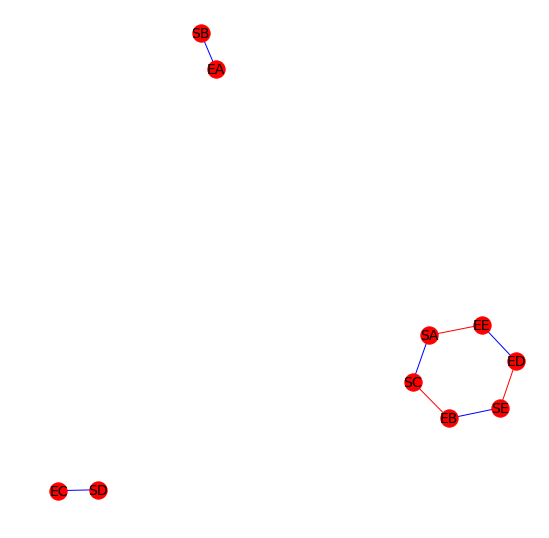

In [6]:
pylab.figure(1,figsize=(7,7))
G=nx.Graph()

for i in EDGES1 :
    G.add_edge(i[0],i[1],color='r')
    
for j in EDGES2 :
    G.add_edge(j[0],j[1],color='b')

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
pos = nx.spring_layout(G, scale=5)
for i in pos:
        pos[i][0] = pos[i][0] * 4 # x coordinate
        pos[i][1] = pos[i][1] * 4 # y coordinate
        
nx.draw(G, pos, edge_color=colors,  with_labels=True, font_size=14)

## Calcul du nombre de cycles

In [7]:
Composantes_connexes =[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

In [8]:
Nb_cycles = len(Composantes_connexes)
print(Nb_cycles)

3


## Nombre d'inversions

In [9]:
Nb_inv = len(d_ref_jouet["Qstart"]) - Nb_cycles
print(Nb_inv)

2


**Remarque :**
    Le nombre de cycles correspond au nombre de composantes connexes.

## Inversions aléatoires

In [10]:
def scenari_aleatoire (QS, QE, SS, SE, inv_obs ,n):
    """ Cette fonction génère des positions aléatoires pour le génome de reférence (Q), et pour le génome d'intérêt (S).
    Puis elle calcule le graph correspndant, à partir de celui-ci, elle infère le nombre d'inversions.
    Cette opération est répétée n fois. Enfin elle retourne la proportion de graphs aléatoirement aléatoirement
    générés qui permettent d'obtenir un nombre d'inversions inférieur à celui observé (inv_obs) """
    
    inv_alea= []
    for i in range(n):
        T1 = QS+QE
        random.shuffle(T1)
        QSshuffled = T1 [:int(len(T1)/2)]
        QEshuflled = T1[int(len(T1)/2) :]
        data_ref = {'Qstart': QSshuffled,'Qend': QEshuflled  }
        data_ref =  pd.DataFrame(data=data_ref)
        data_ref = data_ref.sort_values('Qstart')
        data_ref["ID"]= range(0, len(QSshuffled))
        
        T2 = SS+SE
        random.shuffle(T2)
        SSshuffled = T2 [:int(len(T2)/2)]
        SEshuflled = T2[int(len(T2)/2) :]
        data_int = {'Sstart': SSshuffled,'Send': SEshuflled  }
        data_int =  pd.DataFrame(data=data_int)
        data_int["ID"] = data_ref['ID']
        data_int = data_int.sort_values('Sstart')
        
        EDGES1 = find_edges(data_ref, True)
        EDGES2 = find_edges(data_int, False)
        
        G=nx.Graph()
        for i in EDGES1 :
            G.add_edge(i[0],i[1],color='r')
        for j in EDGES2 :
            G.add_edge(j[0],j[1],color='b')
        Composantes_connexes =[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
        Nb_cycles = len(Composantes_connexes)
        Nb_inv = len(d_ref_jouet["Qstart"]) - Nb_cycles
        inv_alea.append(Nb_inv)
    c =0
    for i in range(n):
        if i < inv_obs:
            c +=1
    p = c/n
    return  p


In [11]:
scenari_aleatoire (list(data_ref["Qstart"]), list(data_ref["Qend"]), list(data_int["Sstart"]), list(data_int["Send"]),Nb_inv  ,20)

0.1

# Analyse du génome de Yersinia pestis CO92

## Importation des données générées sur R

In [12]:
data_ref = pd.read_csv('data_orga_ref.txt', sep="\t")
data_ref.head()

,Qstart,Qend,ID
0,1,168094,1
1,176363,249866,2
2,452842,456700,3
3,514062,518989,4
4,733701,863866,5


In [13]:
data_interest = pd.read_csv('data_orga_interest.txt', sep="\t")
data_interest.head()

,Sstart,Send,ID
0,110552,113114,18
1,403127,571184,1
2,581356,654841,2
3,834860,838718,3
4,1147883,1278062,5


## Recherche des arcs 

In [14]:
EDGES1 = find_edges(data_ref, True)
EDGES2  = find_edges(data_interest, False)
#EDGES1
#EDGES2

##  Représentation du graph 

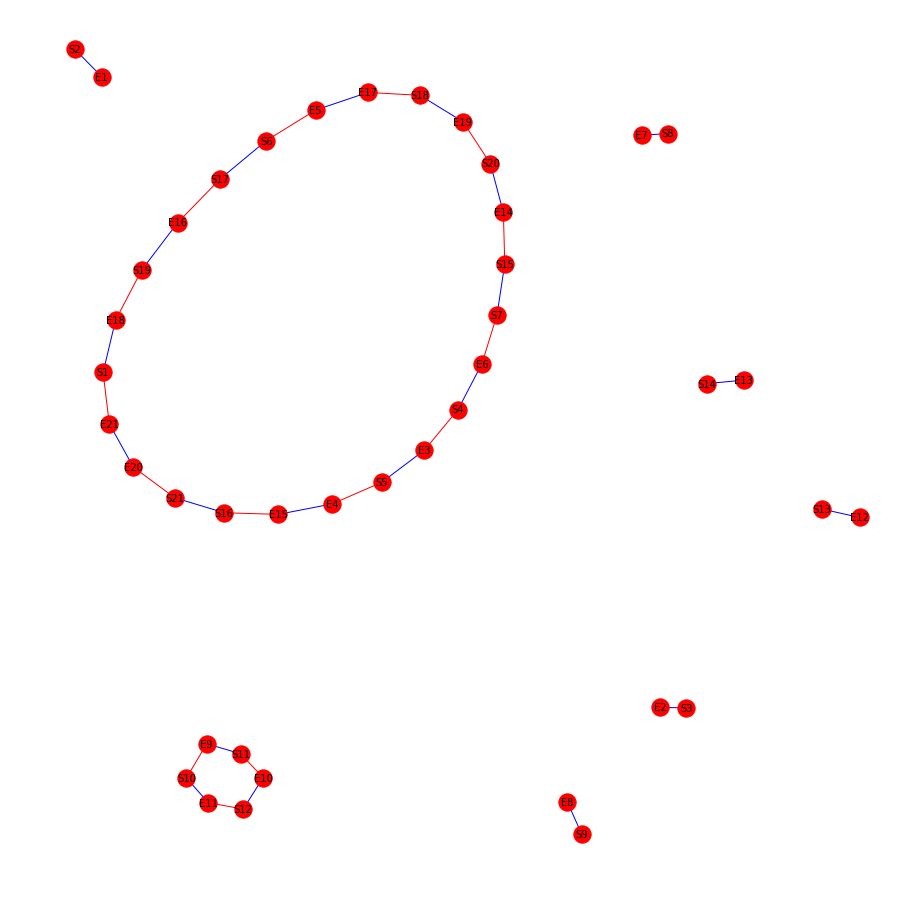

In [15]:
pylab.figure(1,figsize=(12,12))
G=nx.Graph()

for i in EDGES1 :
    G.add_edge(i[0],i[1],color='r', length = 10)
    
for j in EDGES2 :
    G.add_edge(j[0],j[1],color='b', length = 10)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['length'] for u,v in edges]

pos = nx.spring_layout(G, scale=5)
for i in pos:
        pos[i][0] = pos[i][0] * 4 # x coordinate
        pos[i][1] = pos[i][1] * 4 # y coordinate
        
nx.draw(G, pos, edge_color=colors,  with_labels=True, font_size=10)



## Calcul du nombre de cycles

In [16]:
Composantes_connexes =[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
Nb_cycles = len(Composantes_connexes)
print(Nb_cycles)

8


## Nombre d'inversions

In [17]:
Nb_inv = len(data_ref["Qstart"]) - Nb_cycles
print(Nb_inv)

13


## Probabilité d'observer un tel nombre d'inversion sous l'hypothèse du hasard

Nous pouvons décider de fixer un risque  de première espèce $\alpha$ = 0.05

In [18]:
scenari_aleatoire (list(data_ref["Qstart"]), list(data_ref["Qend"]), list(data_interest["Sstart"]), list(data_interest["Send"]),Nb_inv  ,500)

0.026

**Conclusion :** La probabilité d'observer moins de 13 inversions pour 21 gènes orthologes est de 0.026 (après 500 simulations). Nous pouvons rejeter l'hypothèse du hasard au risque de 5%. Les deux organismes sont aparentés